In [1]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", reshape=False)
X_train, y_train           = mnist.train.images, mnist.train.labels
X_validation, y_validation = mnist.validation.images, mnist.validation.labels
X_test, y_test             = mnist.test.images, mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
import numpy as np

# Pad images with 0s
X_train      = np.pad(X_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_validation = np.pad(X_validation, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_test       = np.pad(X_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')
    
print("Updated Image Shape: {}".format(X_train[0].shape))

Updated Image Shape: (32, 32, 1)


In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

In [5]:
import tensorflow as tf

EPOCHS = 1
BATCH_SIZE = 128

In [6]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    #Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    #Activation
    conv1 = tf.nn.relu(conv1)

    #Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    #Activation.
    conv2 = tf.nn.relu(conv2)

    #Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    #Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    #Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    #Activation.
    fc2    = tf.nn.relu(fc2)

    #Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 10), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(10))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    probs = tf.nn.softmax(logits)
    return logits, probs

In [7]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 10)

In [8]:
rate = 0.001

logits = LeNet(x)[0]
probs = tf.nn.softmax(logits=logits)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [9]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [10]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    tf.set_random_seed(40)
    print("Training...")
    print()
    for i in range(EPOCHS):
        tf.set_random_seed(40)
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()    
    saver.save(sess, './lenet')
    print("Model saved")

Training...
()
EPOCH 1 ...
Validation Accuracy = 0.975
()
Model saved


In [11]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.975


In [41]:
def classify(img, correct_class=None, target_class=None):
    img_show = img.reshape(32,32)
    img = img_show.reshape(1,32,32,1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 8))
    fig.sca(ax1)
    p = sess.run(probs, feed_dict={x: img})[0]
    print(p)
    ax1.imshow(img_show)
    fig.sca(ax1)
    
    topk = list(p.argsort()[-10:][::-1])
    topprobs = p[topk]
    barlist = ax2.bar(range(10), topprobs)
    if target_class in topk:
        barlist[topk.index(target_class)].set_color('r')
    if correct_class in topk:
        barlist[topk.index(correct_class)].set_color('g')
    plt.sca(ax2)
    plt.ylim([0, 1.1])
    plt.xticks(range(10),
               [[i] for i in topk],
               rotation='vertical')
    fig.subplots_adjust(bottom=0.2)
    plt.show()

In [160]:
import matplotlib.pyplot as plt
from urllib import urlretrieve
img = X_test[5]

img_class = y_test[5]
#img = PIL.Image.open(img_path)
#new_w = 32 #if not wide else int(img.width * 28 / img.height)
#new_h = 32 #if wide else int(img.height * 28 / img.width)
#img = img.resize((new_w, new_h)).crop((0, 0, 32, 32))
#img_show = img.reshape(32,32)
#img_show = (np.asarray(img) / 255.0).astype(np.float32)
#img = img_show.reshape(1,32,32,1)

[1.3683234e-05 9.9665976e-01 1.2875428e-04 1.3590262e-05 1.1071505e-03
 1.7578964e-06 7.8808253e-06 1.9709440e-03 6.7016721e-05 2.9456987e-05]


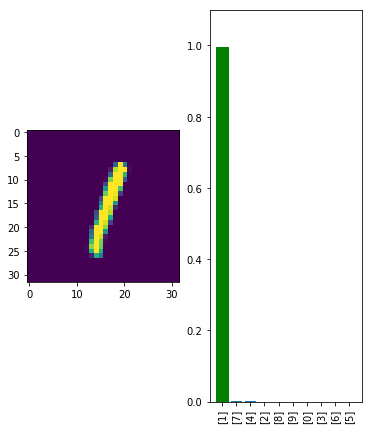

In [161]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    classify(img, correct_class=img_class)

In [431]:
img = X_test[5]
img = img.reshape(1,32,32,1)
x_hat = tf.Variable(tf.zeros((1, 32, 32, 1)))# trainable adversarial input
x_adv =  tf.placeholder(tf.float32, (1, 32, 32, 1))
assign_op = tf.assign(x_hat, x_adv)
logits_hat = LeNet(x_hat)[0]
learning_rate = tf.placeholder(tf.float32, ())
y_hat = tf.placeholder(tf.int32, ()) # Target label
labels_hat = tf.one_hot(y_hat, 10)
loss_hat = tf.nn.softmax_cross_entropy_with_logits(labels=labels_hat,logits=logits_hat)
optim_step = tf.train.AdamOptimizer(learning_rate).minimize(loss_hat, var_list=[x_hat])

In [432]:
epsilon = tf.placeholder(tf.float32, ())
below = x_adv - epsilon
above = x_adv + epsilon
projected = tf.clip_by_value(x_hat, below, above)
with tf.control_dependencies([projected]):
    project_step = tf.assign(x_hat, projected)

In [452]:
# initialization step
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    demo_epsilon = 0.1 # a really small perturbation
    demo_lr = 0.1
    demo_steps = 200
    demo_target = 3
    demo_target = demo_target-1
    #saver.restore(sess, tf.train.latest_checkpoint('.'))
    sess.run(assign_op, feed_dict={x_adv: img})
# projected gradient descent
    for i in range(demo_steps):
    # gradient descent step
        _, loss_value = sess.run([optim_step, loss_hat],feed_dict={learning_rate: demo_lr, y_hat: demo_target})
        #sess.run(project_step, feed_dict={x_adv: img, epsilon: demo_epsilon})
    # project step
        if (i+1) % 100 == 0:
            print('step %d, loss=%g' % (i+1, loss_value))
    x_hat1 = img+demo_epsilon*(x_hat-img)
    x_hat2 = x_hat-img
    adv = x_hat.eval() # retrieve the adversarial example
    adv2 = x_hat2.eval()

step 100, loss=0.0246369
step 200, loss=0.0099993


[6.7428577e-16 8.9741935e-13 9.9862659e-01 1.3734618e-03 1.5590169e-17
 2.3151356e-16 3.2394682e-17 5.3865983e-13 1.9252899e-10 4.5178765e-19]


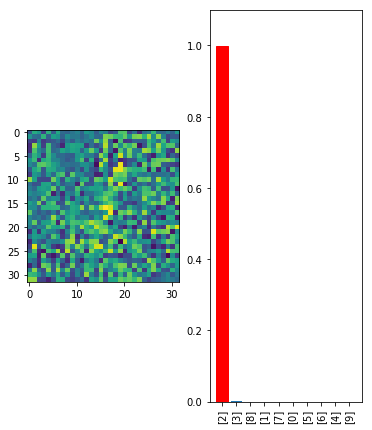

[4.8843199e-06 9.9377316e-01 1.3405903e-03 1.5531911e-04 5.1441562e-04
 9.5518919e-07 3.8315061e-06 4.1139987e-03 8.5095839e-05 7.8131488e-06]


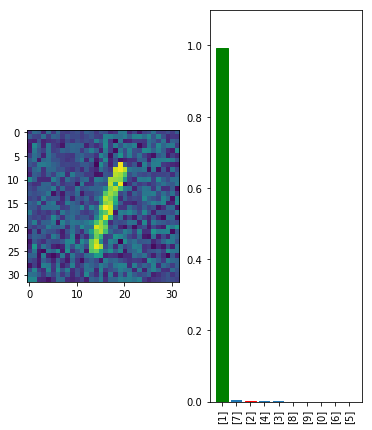

[1.3683234e-05 9.9665976e-01 1.2875428e-04 1.3590262e-05 1.1071505e-03
 1.7578964e-06 7.8808253e-06 1.9709440e-03 6.7016721e-05 2.9456987e-05]


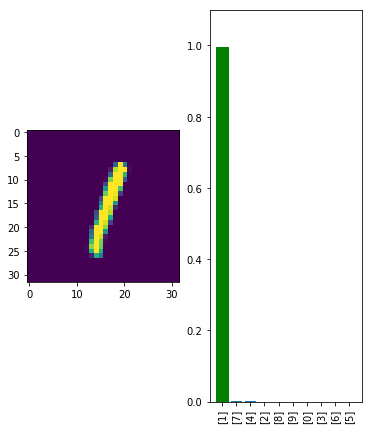

In [449]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    classify(adv, correct_class=img_class,target_class=demo_target)
    classify(adv2, correct_class=img_class,target_class=demo_target)
    classify(img, correct_class=img_class,target_class=demo_target)

In [95]:
def clipped_zoom(img, zoom_factor, **kwargs):

    h, w = img.shape[:2]

    # For multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    # Zooming out
    if zoom_factor < 1:

        # Bounding box of the zoomed-out image within the output array
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        # Zero-padding
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple, **kwargs)
    elif zoom_factor > 1:

        # Bounding box of the zoomed-in region within the input array
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)

        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    # If zoom_factor == 1, just return the input array
    else:
        out = img
    return out

[7.0998457e-04 1.2717371e-02 4.7011863e-02 2.0167897e-02 7.5175816e-01
 5.8823090e-02 7.2000488e-03 1.6919978e-02 1.0350658e-02 7.4340954e-02]


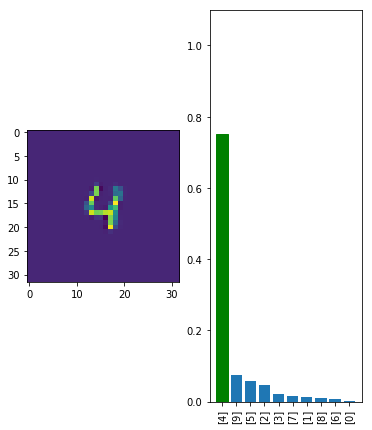

[8.27568670e-07 1.00348949e-07 4.45842670e-06 1.24869555e-08
 9.99294877e-01 1.44560852e-08 4.80085237e-06 3.55668526e-05
 1.53945734e-06 6.57701457e-04]


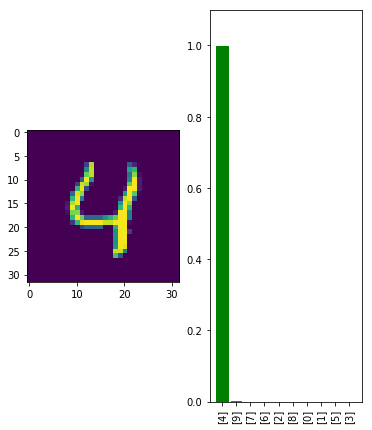

In [122]:
import numpy as np
from scipy.ndimage import zoom


test_aug = clipped_zoom(X_test[4],0.5)
img_aug = test_aug.copy()
#img_aug.resize(1,32,32)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    classify(img_aug, correct_class=y_test[4])
    classify(X_test[4], correct_class=y_test[4])
    

[1.0003689e-03 8.1474145e-06 2.6525394e-03 1.8509347e-06 9.8541301e-01
 3.0396563e-06 2.6562670e-03 1.8145764e-03 3.5953135e-06 6.4466144e-03]


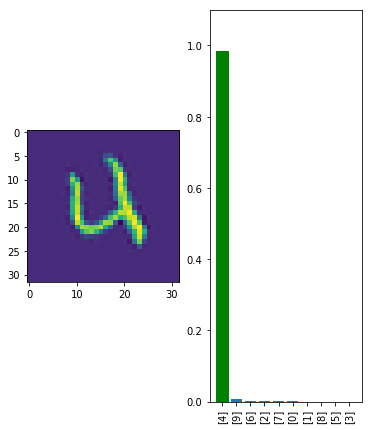

[1.3822408e-02 7.4279647e-05 5.8439600e-01 7.8227336e-04 7.9156898e-02
 6.2947744e-05 3.0239506e-03 2.6172465e-01 1.5423102e-04 5.6802452e-02]


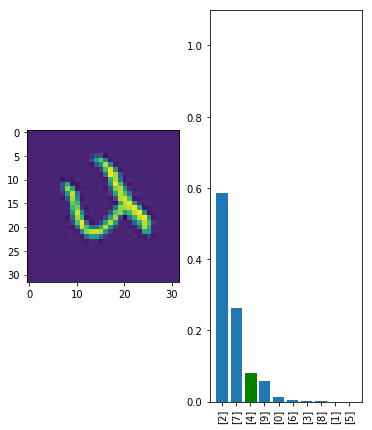

In [120]:
from scipy.ndimage import rotate
from scipy.misc import face
from matplotlib import pyplot as plt
img = X_test[4]
rot_aug30 = rotate(img, 30, reshape=False)
rot_aug45 = rotate(img, 45, reshape=False)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    classify(rot_aug30, correct_class=y_test[4])
    classify(rot_aug45, correct_class=y_test[4])
